# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [ ]:
# verifty notebook is running on a GPU (pay-as-you-go is $9.99/100 units if free limit is reached)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Aug 18 18:21:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend
import random
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# to display images in colab using OpenCV
from google.colab.patches import cv2_imshow



## Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load the images
images = np.load('/content/drive/MyDrive/Colab Notebooks/AIML computer vision/Plant Classification/images.npy')

# load the labels
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIML computer vision/Plant Classification/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [ ]:
images.shape

(4750, 128, 128, 3)

There are 4750 images that are 128x128 3 channel (RGB) images

In [ ]:
labels.shape

(4750, 1)

There are 4750 labels

In [ ]:
labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


In [ ]:
labels.describe()

,Label
count,4750
unique,12
top,Loose Silky-bent
freq,654


There are no null values.

There are 12 unique values or labels

Loose Silky-bent is the most common, with 654 out of 4750

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [ ]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

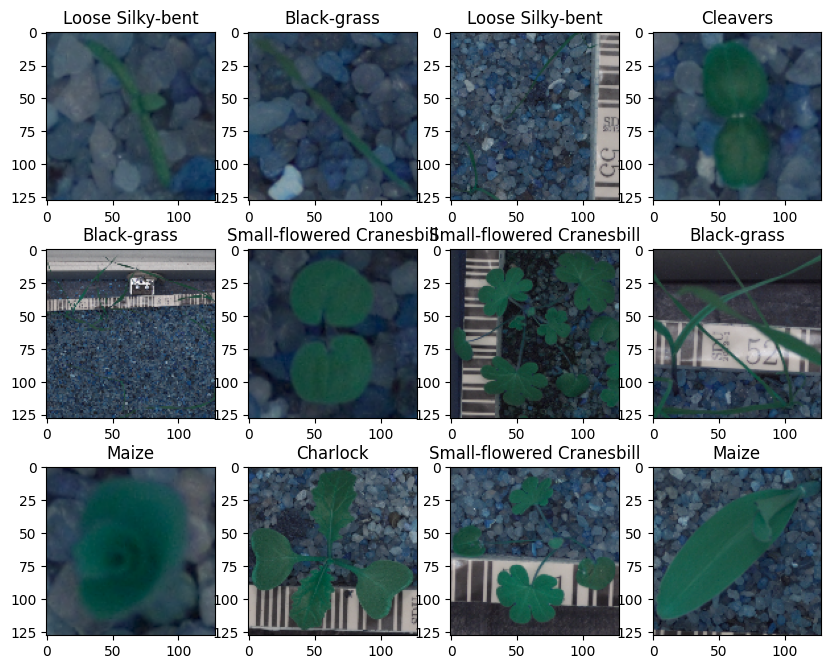

In [ ]:
plot_images(images, labels)

The images are similar in that they are young seedlings iln a bed of small granular material or small rocks.  

Some of the images have a scale of some kind (black and white barred ruler?)

They could be BGR images displayed in RGB, will convert and see if they look any better.

Will check the balance of the dataset.

In [ ]:
def labeled_barplot(data, feature, perc=False, n=None):
  '''
  Barplot with percentage at the top
  data: dataframe
  feature: dataframe column
  perc:
  whether to display percentages instead of count (default is False)
  n: displays the top n category levels (defaul is None, i.e., display all levels)
  '''
  total = len(data[feature]) #length of the column
  count = data[feature].nunique()
  if n is None:
    plt.figure(figsize=(count + 2, 6))
  else:
    plt.figure(figsize=(n + 2, 6))
  plt.xticks(rotation=90, fontsize=15)
  ax = sns.countplot(
      data=data,
      x=feature,
      palette='Paired',
      order=data[feature].value_counts().index[:n]
  )
  for p in ax.patches:
    if perc == True:
      label = '{:.1f}%'.format(
          100*p.get_height()/total
      ) # percentage of each class of the category
    else:
      label = p.get_height() # count of each level of the category
    x = p.get_x() + p.get_width()/2 # width of the plot
    y = p.get_height() # height of the plot

    #annotate the percentage
    ax.annotate(
        label,
        (x, y),
        ha='center',
        va='center',
        size=12,
        xytext=(0,5),
        textcoords='offset points',
    )
plt.show()

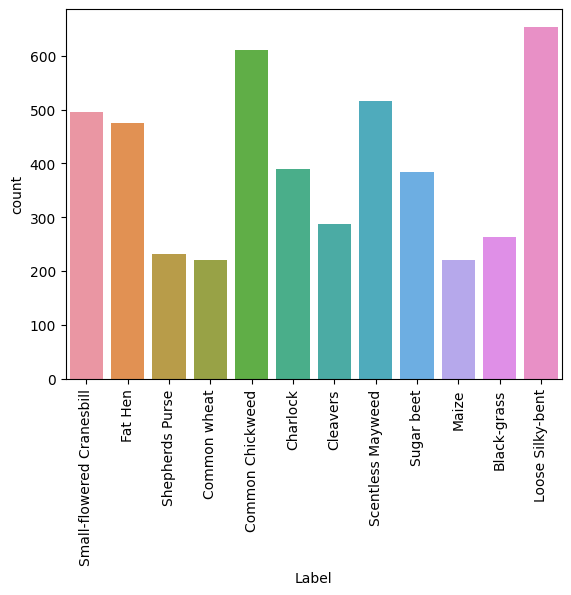

In [ ]:
# visualize the balance of the dataset
sns.countplot(data = labels, x='Label');
plt.xticks(rotation=90)
plt.show()

In [ ]:
# number of labels for each plant type
labels['Label'].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64

In [ ]:
# check the percentage of each label value
for i in labels['Label'].unique():
  print(i, ": ", (labels[labels['Label']==i].count()/labels.shape[0])*100, "\n")

Small-flowered Cranesbill :  Label    10.442105
dtype: float64 

Fat Hen :  Label    10.0
dtype: float64 

Shepherds Purse :  Label    4.863158
dtype: float64 

Common wheat :  Label    4.652632
dtype: float64 

Common Chickweed :  Label    12.863158
dtype: float64 

Charlock :  Label    8.210526
dtype: float64 

Cleavers :  Label    6.042105
dtype: float64 

Scentless Mayweed :  Label    10.863158
dtype: float64 

Sugar beet :  Label    8.105263
dtype: float64 

Maize :  Label    4.652632
dtype: float64 

Black-grass :  Label    5.536842
dtype: float64 

Loose Silky-bent :  Label    13.768421
dtype: float64 



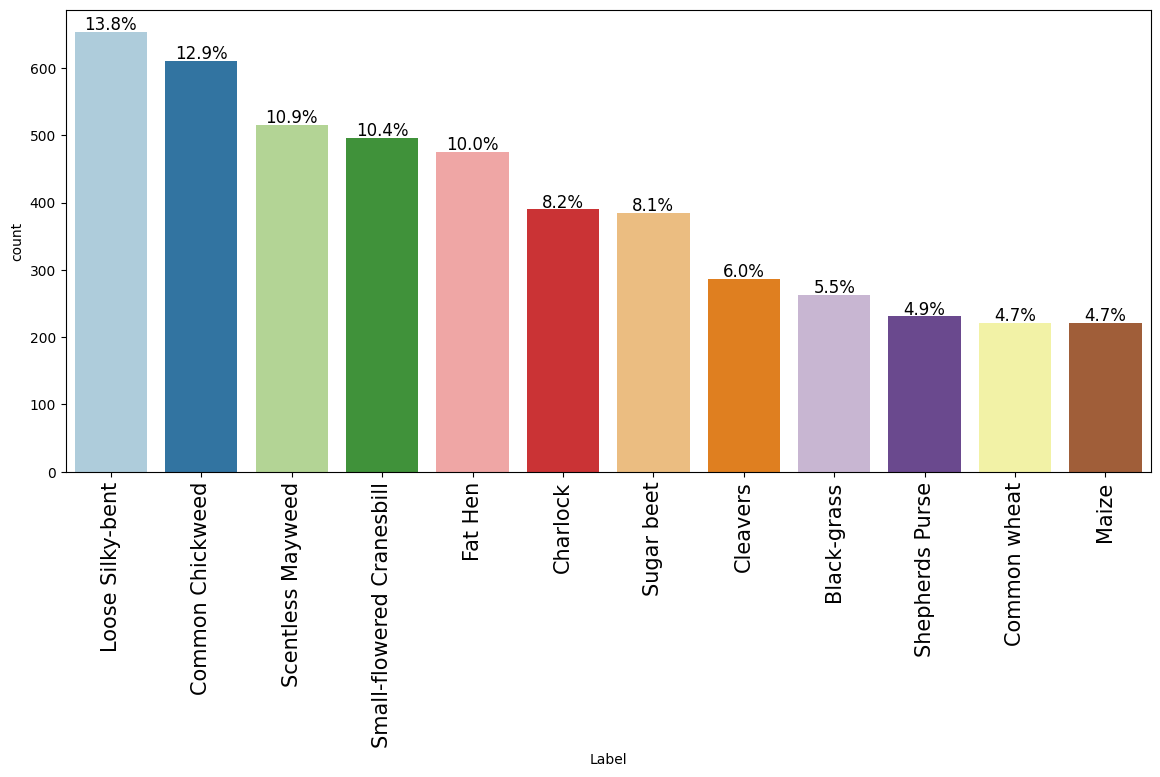

In [ ]:
# Visualize the balance/distribution of the label values.
labeled_barplot(labels, "Label", perc=True)

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [ ]:
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

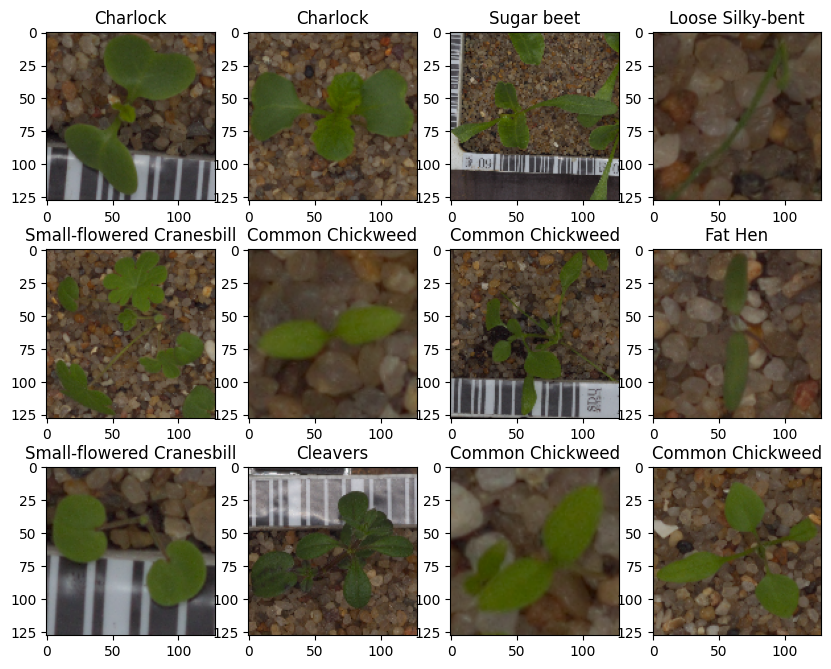

In [ ]:
plot_images(images, labels)

This coloration looks much more natural, will continue with the images converted to RGB.


### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:
images_decreased = []
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))


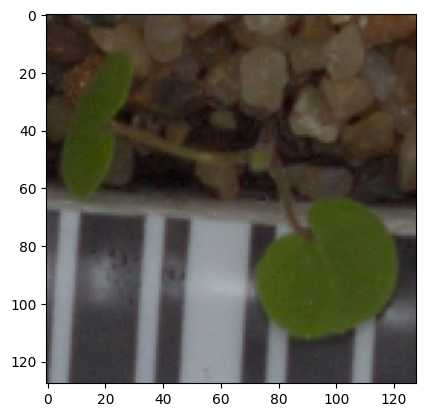

In [ ]:
plt.imshow(images[10])


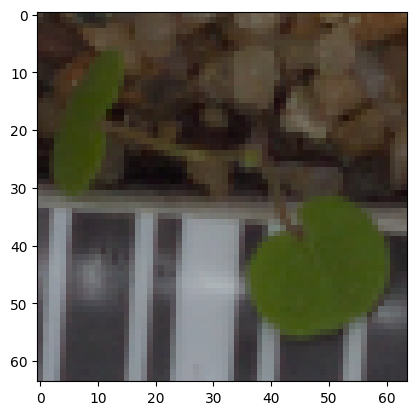

In [ ]:
plt.imshow(images_decreased[10])

The reduced images are slightly pixelated, will try a Gaussian Blur

In [ ]:
images_gb = []
for i in range(len(images_decreased)):
  images_gb.append(cv2.GaussianBlur(images_decreased[i], ksize=(3,3), sigmaX=0))

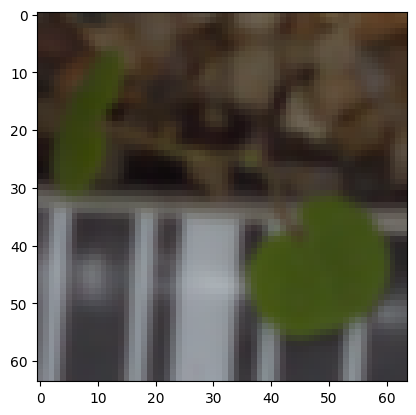

In [ ]:
plt.imshow(images_gb[10])

The Gaussian Blur has made the images less distinct, will use the images_decreased set for the initial model training.

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased), labels, test_size=0.1, random_state=1, stratify=labels)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.1, random_state=1, stratify = y_temp)

In [ ]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


X_train: (3847, 64, 64, 3)
y_train: (3847, 1)
X_val: (428, 64, 64, 3)
y_val: (428, 1)
X_test: (475, 64, 64, 3)
y_test: (475, 1)


### Encode the target labels

In [ ]:
# convert the labels from names to OHE vectors
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded = enc.transform(y_val)
y_test_encoded = enc.transform(y_test)

### Data Normalization

In [ ]:
# normalize the pixel values, convert from 0-255 to 0-1
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

### Model1

In [ ]:
# clearing the backend and setting the seeds
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

The first, baseline model, will be a CNN without batch normalization or dropout.  Depending on performance, will add these layers as necessary.

In [ ]:
# initialize the model as sequential
model1 = Sequential()

In [ ]:
# start with a conv layer
model1.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(64,64,3)))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model1.add(MaxPooling2D(2,2))

# flatten
model1.add(Flatten())

# ANN layers
model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(16, activation='relu'))

#output layer
model1.add(Dense(12, activation='softmax'))

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 16)         0

In [ ]:
history1 = model1.fit(X_train_normalized, y_train_encoded,
                    validation_data=(X_val_normalized, y_val_encoded),
                    epochs=10,
                    batch_size=32,
                    verbose=2
)

Epoch 1/10
121/121 - 13s - loss: 2.4294 - accuracy: 0.1209 - val_loss: 2.2949 - val_accuracy: 0.2266 - 13s/epoch - 105ms/step
Epoch 2/10
121/121 - 1s - loss: 2.0723 - accuracy: 0.3202 - val_loss: 1.8384 - val_accuracy: 0.3949 - 549ms/epoch - 5ms/step
Epoch 3/10
121/121 - 1s - loss: 1.5243 - accuracy: 0.4731 - val_loss: 1.6273 - val_accuracy: 0.4065 - 546ms/epoch - 5ms/step
Epoch 4/10
121/121 - 1s - loss: 1.2334 - accuracy: 0.5758 - val_loss: 1.2012 - val_accuracy: 0.6285 - 537ms/epoch - 4ms/step
Epoch 5/10
121/121 - 1s - loss: 1.0905 - accuracy: 0.6194 - val_loss: 1.1019 - val_accuracy: 0.6589 - 547ms/epoch - 5ms/step
Epoch 6/10
121/121 - 1s - loss: 0.9902 - accuracy: 0.6522 - val_loss: 1.2258 - val_accuracy: 0.6028 - 575ms/epoch - 5ms/step
Epoch 7/10
121/121 - 1s - loss: 0.9339 - accuracy: 0.6686 - val_loss: 1.2117 - val_accuracy: 0.5935 - 568ms/epoch - 5ms/step
Epoch 8/10
121/121 - 1s - loss: 0.8352 - accuracy: 0.7112 - val_loss: 1.0555 - val_accuracy: 0.6729 - 579ms/epoch - 5ms/step

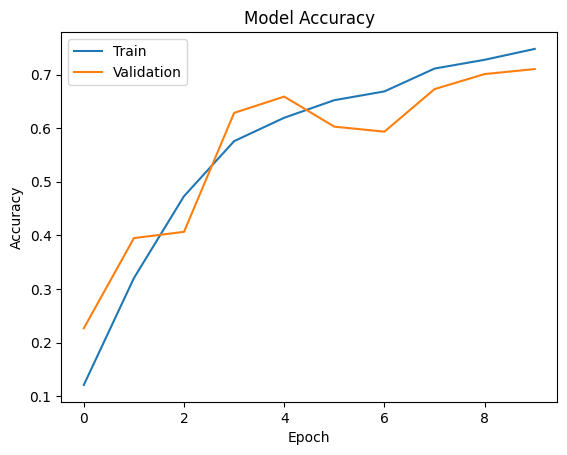

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.9350 - accuracy: 0.6842 - 103ms/epoch - 7ms/step


15/15 [==============================] - 0s 2ms/step


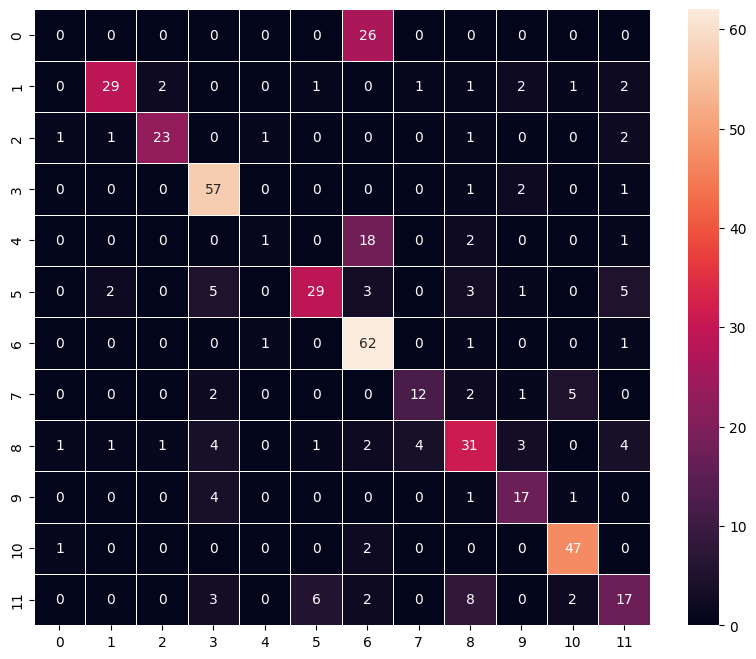

In [ ]:
y_pred1 = model1.predict(X_test_normalized)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred1_arg=np.argmax(y_pred1,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred1_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [ ]:
cr1 =metrics.classification_report(y_test_arg,y_pred1_arg, output_dict=True)
f1_1 = cr1['macro avg']['f1-score']
acc_1 = cr1['accuracy']
print('f1-score:',f1_1)
print('Accuracy:', acc_1)


f1-score: 0.600688826862237
Accuracy: 0.6842105263157895


The initial model trained nicely, it is a little over fit above 5 epochs, but accuracy is not great (68%).  

Will try some Batch Norm and Dropout layers

### Model2

In [ ]:
# clearing the backend and setting the seeds
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
# initialize the model as sequential
model2 = Sequential()

In [ ]:
# start with a conv layer
model2.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(64,64,3)))
model2.add(MaxPooling2D(2,2))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model2.add(MaxPooling2D(2,2))
model2.add(BatchNormalization())
model2.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model2.add(MaxPooling2D(2,2))
model2.add(BatchNormalization())

# flatten
model2.add(Flatten())

# ANN layers
model2.add(Dense(64, activation='relu'))
model2.add(Dropout((0.25)))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout((0.25)))
model2.add(Dense(16, activation='relu'))

#output layer
model2.add(Dense(12, activation='softmax'))

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                        

In [ ]:
history2 = model2.fit(X_train_normalized, y_train_encoded,
                    validation_data=(X_val_normalized, y_val_encoded),
                    epochs=50,
                    batch_size=32,
                    verbose=2,
)

Epoch 1/50
121/121 - 4s - loss: 2.3437 - accuracy: 0.1916 - val_loss: 2.6577 - val_accuracy: 0.1379 - 4s/epoch - 37ms/step
Epoch 2/50
121/121 - 1s - loss: 1.8276 - accuracy: 0.4143 - val_loss: 3.2460 - val_accuracy: 0.1379 - 643ms/epoch - 5ms/step
Epoch 3/50
121/121 - 1s - loss: 1.4436 - accuracy: 0.5285 - val_loss: 4.2174 - val_accuracy: 0.1379 - 674ms/epoch - 6ms/step
Epoch 4/50
121/121 - 1s - loss: 1.2251 - accuracy: 0.5883 - val_loss: 2.8611 - val_accuracy: 0.2103 - 657ms/epoch - 5ms/step
Epoch 5/50
121/121 - 1s - loss: 1.0433 - accuracy: 0.6434 - val_loss: 1.2418 - val_accuracy: 0.5888 - 668ms/epoch - 6ms/step
Epoch 6/50
121/121 - 1s - loss: 0.9117 - accuracy: 0.6896 - val_loss: 0.8095 - val_accuracy: 0.7500 - 681ms/epoch - 6ms/step
Epoch 7/50
121/121 - 1s - loss: 0.7750 - accuracy: 0.7320 - val_loss: 0.9311 - val_accuracy: 0.7009 - 696ms/epoch - 6ms/step
Epoch 8/50
121/121 - 1s - loss: 0.7335 - accuracy: 0.7544 - val_loss: 1.2143 - val_accuracy: 0.6332 - 685ms/epoch - 6ms/step
Ep

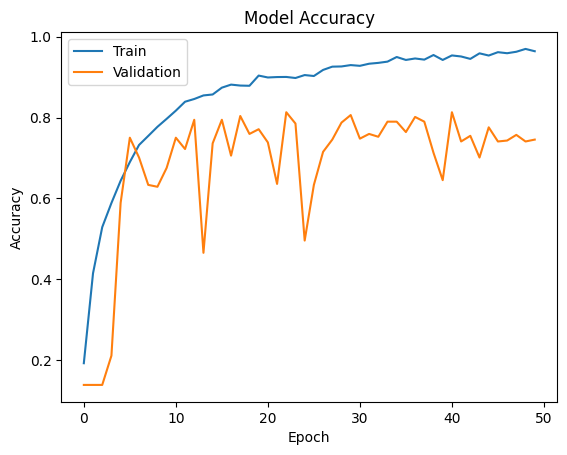

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.6432 - accuracy: 0.7579 - 61ms/epoch - 4ms/step


15/15 [==============================] - 0s 2ms/step


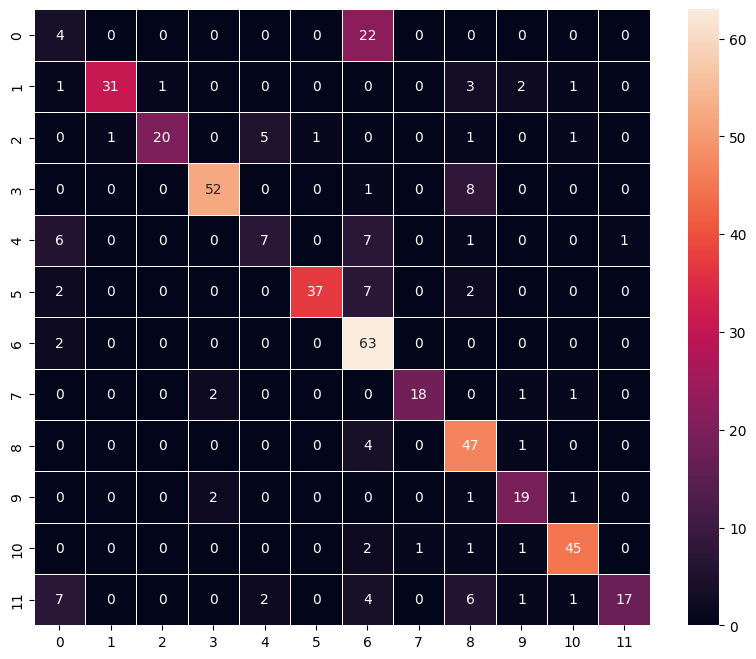

In [ ]:
y_pred2 = model2.predict(X_test_normalized)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred2_arg=np.argmax(y_pred2,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred2_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [ ]:
cr2 =metrics.classification_report(y_test_arg,y_pred2_arg, output_dict=True)
f1_2 = cr2['macro avg']['f1-score']
acc_2 = cr2['accuracy']
print('f1-score:',f1_2)
print('Accuracy:', acc_2)


f1-score: 0.720458258743271
Accuracy: 0.7578947368421053


Adding Batch Normalization, Dropout, the accuracy improved to about 78%.  

There was very little improvement after the 10th epoch

### Model3

In [ ]:
# clearing the backend and setting the seeds
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
# initialize the model as sequential
model3 = Sequential()

In [ ]:
# start with a conv layer
model3.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(64,64,3)))
model3.add(MaxPooling2D(2,2))
model3.add(BatchNormalization())
model3.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model3.add(MaxPooling2D(2,2))
model3.add(BatchNormalization())
model3.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model3.add(MaxPooling2D(2,2))
model3.add(BatchNormalization())

# flatten
model3.add(Flatten())

# ANN layers
model3.add(Dense(64, activation='relu'))
model3.add(Dropout((0.25)))
model3.add(BatchNormalization())
model3.add(Dense(32, activation='relu'))
model3.add(Dropout((0.25)))
model3.add(BatchNormalization())
model3.add(Dense(32, activation='relu'))
model3.add(Dropout((0.25)))
model3.add(BatchNormalization())
model3.add(Dense(16, activation='relu'))
model3.add(BatchNormalization())
#output layer
model3.add(Dense(12, activation='softmax'))

In [ ]:
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                        

In [ ]:
history3 = model3.fit(X_train_normalized, y_train_encoded,
                    validation_data=(X_val_normalized, y_val_encoded),
                    epochs=50,
                    batch_size=32,
                    verbose=2,
                    )

Epoch 1/50
121/121 - 7s - loss: 2.6630 - accuracy: 0.1139 - val_loss: 2.4867 - val_accuracy: 0.0561 - 7s/epoch - 56ms/step
Epoch 2/50
121/121 - 1s - loss: 2.2403 - accuracy: 0.2332 - val_loss: 2.9311 - val_accuracy: 0.1379 - 1s/epoch - 8ms/step
Epoch 3/50
121/121 - 1s - loss: 1.9044 - accuracy: 0.3754 - val_loss: 2.8275 - val_accuracy: 0.1425 - 964ms/epoch - 8ms/step
Epoch 4/50
121/121 - 1s - loss: 1.7386 - accuracy: 0.4203 - val_loss: 2.7453 - val_accuracy: 0.1589 - 961ms/epoch - 8ms/step
Epoch 5/50
121/121 - 1s - loss: 1.5931 - accuracy: 0.4598 - val_loss: 1.6195 - val_accuracy: 0.4252 - 947ms/epoch - 8ms/step
Epoch 6/50
121/121 - 1s - loss: 1.4943 - accuracy: 0.5017 - val_loss: 1.5014 - val_accuracy: 0.4603 - 911ms/epoch - 8ms/step
Epoch 7/50
121/121 - 1s - loss: 1.4289 - accuracy: 0.5173 - val_loss: 1.7324 - val_accuracy: 0.4206 - 923ms/epoch - 8ms/step
Epoch 8/50
121/121 - 1s - loss: 1.3435 - accuracy: 0.5555 - val_loss: 1.2287 - val_accuracy: 0.5981 - 914ms/epoch - 8ms/step
Epoch

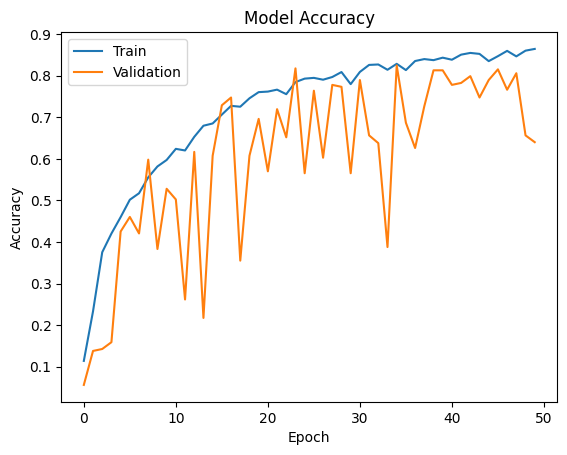

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model3.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.2176 - accuracy: 0.6653 - 66ms/epoch - 4ms/step


15/15 [==============================] - 0s 3ms/step


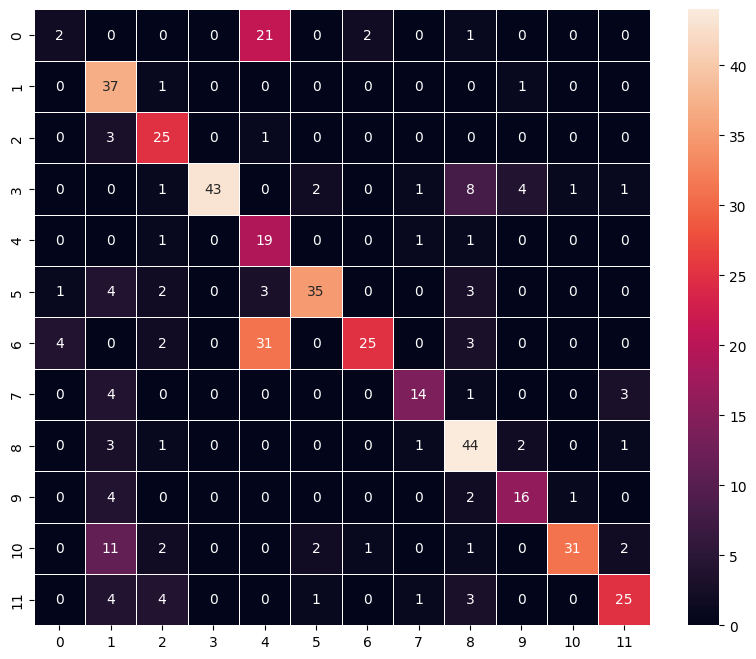

In [ ]:
y_pred3 = model3.predict(X_test_normalized)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred3_arg=np.argmax(y_pred3,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred3_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [ ]:
cr3 =metrics.classification_report(y_test_arg,y_pred3_arg, output_dict=True)
f1_3 = cr3['macro avg']['f1-score']
acc_3 = cr3['accuracy']
print('f1-score:',f1_3)
print('Accuracy:', acc_3)


f1-score: 0.6402992973377218
Accuracy: 0.6652631578947369


Batch Norm in the ANN section caused a decrease in the accuracy.

Will keep Batch Norm in CNN section, drop batch norm in the ANN section, (return to model2) but will add ReduceLROnPlateau and see if that helps.

### Model4

In [ ]:
# clearing the backend and setting the seeds
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
# initialize the model as sequential
model4 = Sequential()

In [ ]:
# start with a conv layer
model4.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(64,64,3)))
model4.add(MaxPooling2D(2,2))
model4.add(BatchNormalization())
model4.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model4.add(MaxPooling2D(2,2))
model4.add(BatchNormalization())
model4.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model4.add(MaxPooling2D(2,2))
model4.add(BatchNormalization())

# flatten
model4.add(Flatten())

# ANN layers
model4.add(Dense(64, activation='relu'))
model4.add(Dropout((0.25)))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout((0.25)))
model4.add(Dense(16, activation='relu'))

#output layer
model4.add(Dense(12, activation='softmax'))

In [ ]:
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                        

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5,) #restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, mode='auto', min_delta=0.00001)
callbacks = (early_stop, reduce_lr)

history4 = model4.fit(X_train_normalized, y_train_encoded,
                    validation_data=(X_val_normalized, y_val_encoded),
                    epochs=50,
                    batch_size=32,
                    verbose=2,
                    callbacks=callbacks
)

Epoch 1/50
121/121 - 4s - loss: 2.3326 - accuracy: 0.1924 - val_loss: 2.5390 - val_accuracy: 0.1379 - lr: 0.0010 - 4s/epoch - 37ms/step
Epoch 2/50
121/121 - 1s - loss: 1.8273 - accuracy: 0.4156 - val_loss: 3.3439 - val_accuracy: 0.1379 - lr: 0.0010 - 595ms/epoch - 5ms/step
Epoch 3/50
121/121 - 1s - loss: 1.4472 - accuracy: 0.5386 - val_loss: 3.9202 - val_accuracy: 0.1355 - lr: 0.0010 - 633ms/epoch - 5ms/step
Epoch 4/50
121/121 - 1s - loss: 1.2086 - accuracy: 0.6036 - val_loss: 4.1577 - val_accuracy: 0.1402 - lr: 5.0000e-04 - 700ms/epoch - 6ms/step
Epoch 5/50
121/121 - 1s - loss: 1.0541 - accuracy: 0.6449 - val_loss: 1.4520 - val_accuracy: 0.5280 - lr: 5.0000e-04 - 658ms/epoch - 5ms/step
Epoch 6/50
121/121 - 1s - loss: 0.9455 - accuracy: 0.6847 - val_loss: 1.0486 - val_accuracy: 0.6752 - lr: 5.0000e-04 - 646ms/epoch - 5ms/step
Epoch 7/50
121/121 - 1s - loss: 0.8250 - accuracy: 0.7260 - val_loss: 1.0767 - val_accuracy: 0.6612 - lr: 5.0000e-04 - 604ms/epoch - 5ms/step
Epoch 8/50
121/121 -

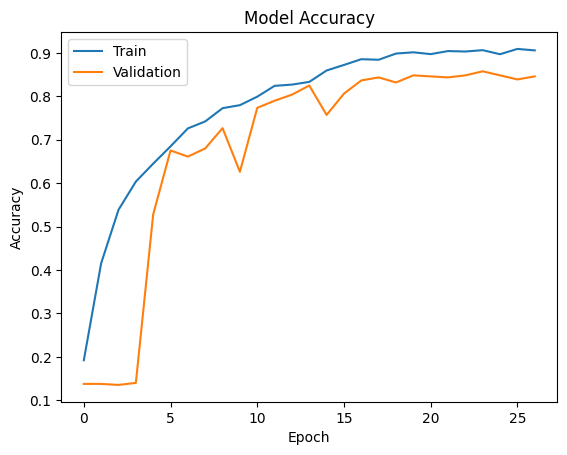

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model4.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.4941 - accuracy: 0.8568 - 57ms/epoch - 4ms/step


15/15 [==============================] - 0s 2ms/step


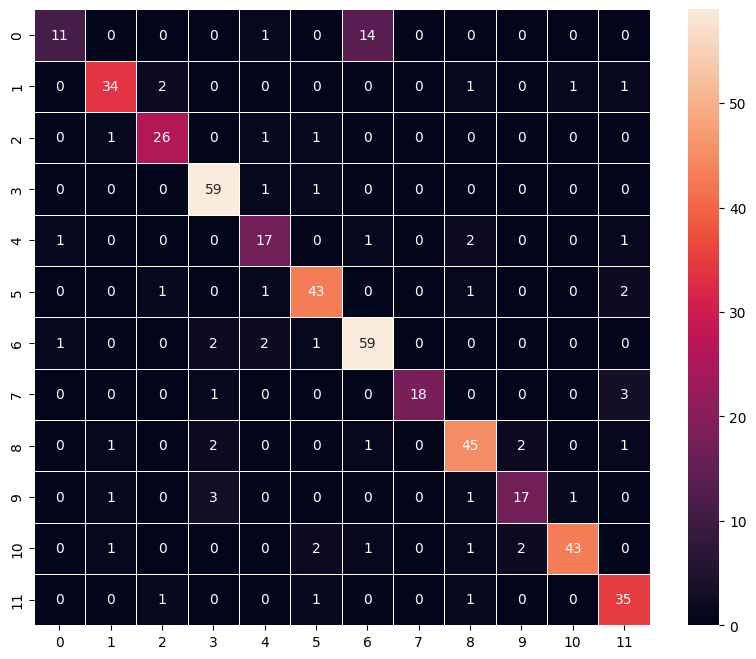

In [ ]:
y_pred4 = model4.predict(X_test_normalized)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred4_arg=np.argmax(y_pred4,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred4_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [ ]:
cr4 =metrics.classification_report(y_test_arg,y_pred4_arg, output_dict=True)
f1_4 = cr4['macro avg']['f1-score']
acc_4 = cr4['accuracy']
print('f1-score:',f1_4)
print('Accuracy:', acc_4)


f1-score: 0.8364213235514716
Accuracy: 0.8568421052631578


Will now try data augmentation on the best model, so far, model4 with Batch Norm in the CNN side, Dropout on the ANN side, and utilizing ReduceLROnPlateau with a factor of 0.5

### Model5

#### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
# clearing the backend and setting the seeds
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
datagen = ImageDataGenerator (horizontal_flip=True,
                                    vertical_flip=False,
                                    height_shift_range=0.1,
                                    width_shift_range=0.1,
                                    rotation_range=90,
                                    zoom_range=0.1,
                                    )

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, start_from_epoch=15) #restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', min_delta=0.00001)
callbacks = (early_stop, reduce_lr)
model5 = model4
history5 = model5.fit(datagen.flow(X_train_normalized, y_train_encoded),
                    validation_data=(X_val_normalized, y_val_encoded),
                    epochs=50,
                    verbose=2,
                    batch_size=32,
                    steps_per_epoch=X_train.shape[0]/32,
                    callbacks=callbacks
)

Epoch 1/50
120/120 - 6s - loss: 1.0209 - accuracy: 0.7050 - val_loss: 0.6467 - val_accuracy: 0.8271 - lr: 1.5625e-05 - 6s/epoch - 46ms/step
Epoch 2/50
120/120 - 5s - loss: 0.9814 - accuracy: 0.7024 - val_loss: 0.6087 - val_accuracy: 0.8224 - lr: 1.5625e-05 - 5s/epoch - 40ms/step
Epoch 3/50
120/120 - 5s - loss: 0.9468 - accuracy: 0.7057 - val_loss: 0.5963 - val_accuracy: 0.8224 - lr: 1.5625e-05 - 5s/epoch - 38ms/step
Epoch 4/50
120/120 - 5s - loss: 0.9424 - accuracy: 0.7083 - val_loss: 0.5912 - val_accuracy: 0.8271 - lr: 1.5625e-05 - 5s/epoch - 38ms/step
Epoch 5/50
120/120 - 5s - loss: 0.9364 - accuracy: 0.7125 - val_loss: 0.5971 - val_accuracy: 0.8224 - lr: 1.5625e-05 - 5s/epoch - 38ms/step
Epoch 6/50
120/120 - 5s - loss: 0.8975 - accuracy: 0.7195 - val_loss: 0.6369 - val_accuracy: 0.8201 - lr: 1.5625e-05 - 5s/epoch - 39ms/step
Epoch 7/50
120/120 - 5s - loss: 0.8775 - accuracy: 0.7190 - val_loss: 0.6054 - val_accuracy: 0.8294 - lr: 1.5625e-06 - 5s/epoch - 38ms/step
Epoch 8/50
120/120 -

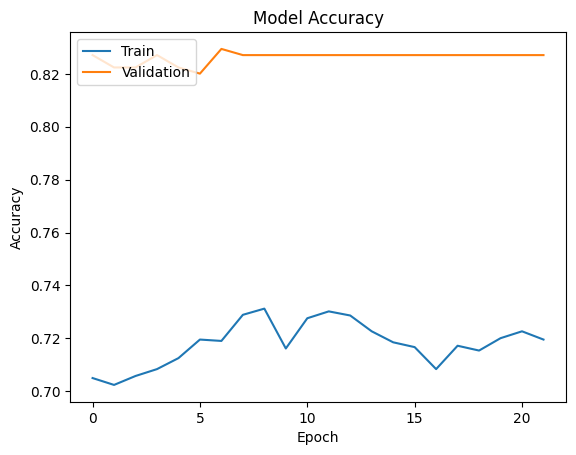

In [ ]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model5.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.5019 - accuracy: 0.8400 - 58ms/epoch - 4ms/step


15/15 [==============================] - 0s 3ms/step


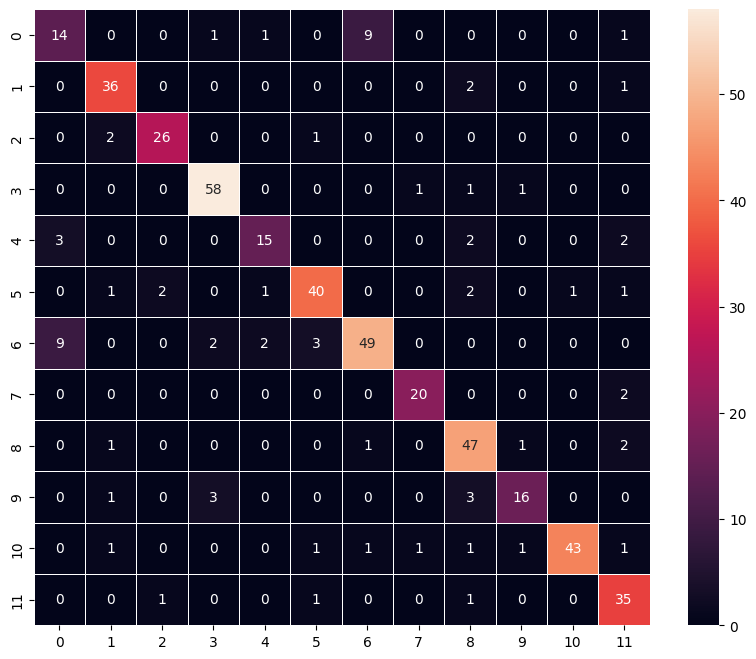

In [ ]:
y_pred5 = model5.predict(X_test_normalized)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred5_arg=np.argmax(y_pred5,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred5_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [ ]:
cr5 =metrics.classification_report(y_test_arg,y_pred5_arg, output_dict=True)
f1_5 = cr5['macro avg']['f1-score']
acc_5 = cr5['accuracy']
print('f1-score:',f1_5)
print('Accuracy:', acc_5)


f1-score: 0.8245652439323717
Accuracy: 0.84


In [ ]:
cnn_compare = pd.DataFrame({'Model1':[f1_1, acc_1],
                            'Model2':[f1_2, acc_2],
                            'Model3':[f1_3, acc_3],
                            'Model4':[f1_4, acc_4],
                            'Model5':[f1_5, acc_5]
                            },
                            index=['f1', 'acc'])
cnn_compare

,Model1,Model2,Model3,Model4,Model5
f1,0.600689,0.720458,0.640299,0.836421,0.824565
acc,0.684211,0.757895,0.665263,0.856842,0.840000


Utilizing batch norm on the CNN side, reduceonplateau, and data augmentation, model5 is about 85% accurate on test data.

Model4, no augmentation is slightly better at 86% accurate on test data.

will use model 4 for the initial xfer model


In [ ]:
labels['Label'].unique()

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

## Transfer Learning VGG16 and Imagenet

- Now, let's try again, but this time, using the idea of **Transfer Learning**. We will be loading a pre-built architecture - **VGG16**, which was trained on the ImageNet dataset and finished runner-up in the ImageNet competition in 2014. Below is a schematic of the VGG16 model.

- For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. We will remove the already-present fully-connected layers and add our own fully-connected layers for this binary classification task.


![vgg16](https://upload.wikimedia.org/wikipedia/commons/2/24/VGG16.png)

In [ ]:
#Summary of the VGG16 model
model_vgg = VGG16(weights='imagenet')
model_vgg.summary()

553467096/553467096 [==============================] - 16s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

We can see that the input shape for VGG16 is 224x224x3.

Will need to resize the images to 224x224.

Will convert the original images (128x128) instead of converting the decreased 64x64 images.

In [ ]:
images_increased = []
height = 224
width = 224
dimensions = (width, height)
for i in range(len(images)):
  images_increased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

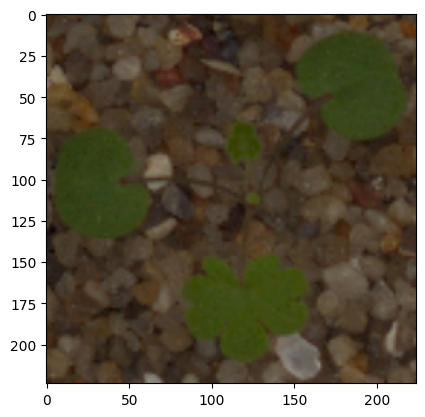

In [ ]:
# view a newly resized (22x224) image to check for quality and/or distortion
plt.imshow(images_increased[1])

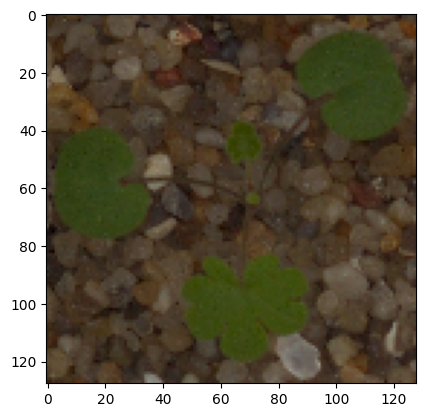

In [ ]:
# view an original (128x128) image for comparison
plt.imshow(images[1])

### Data Preparation for Modeling with INCREASED Image size

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [ ]:
X_temp1, X_test1, y_temp1, y_test1 = train_test_split(np.array(images_increased), labels, test_size=0.1, random_state=1, stratify=labels)

In [ ]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_temp1, y_temp1, test_size = 0.1, random_state=1, stratify = y_temp)

In [ ]:
print("X_train1:", X_train1.shape)
print("y_train1:", y_train1.shape)
print("X_val1:", X_val1.shape)
print("y_val1:", y_val1.shape)
print("X_test1:", X_test1.shape)
print("y_test1:", y_test1.shape)


X_train1: (3847, 224, 224, 3)
y_train1: (3847, 1)
X_val1: (428, 224, 224, 3)
y_val1: (428, 1)
X_test1: (475, 224, 224, 3)
y_test1: (475, 1)


### Encode the target labels

In [ ]:
# convert the labels from names to OHE vectors
enc = LabelBinarizer()
y_train_encoded1 = enc.fit_transform(y_train1)
y_val_encoded1 = enc.transform(y_val1)
y_test_encoded1 = enc.transform(y_test1)

### Data Normalization

In [ ]:
# normalize the pixel values, convert from 0-255 to 0-1
X_train_normalized1 = X_train1.astype('float32')/255.0
X_val_normalized1 = X_val1.astype('float32')/255.0
X_test_normalized1 = X_test1.astype('float32')/255.0

resizing to a larger pixel count seems to have no negative effect on the images.

Now, will use these larger images on a transfer model (VGG16)

Will start with 'block5_pool' and scale back from there if needs be.

### Model6 VGG with dense layers from model4

In [ ]:

model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
model_vgg.summary()

#alternatively if you are NOT taking all CNN layers and dropping only the fully connected side:
# this will let you specify the up-to-and-include cnn layer you want
# in this case 'block5_pool' is the last layer, so both options will return the same, but you can adjust the layer arg
# xfer_layer = model_vgg.get_layer('block5_pool')
# model_vgg = Model(inputs=model_vgg.input, outputs=xfer_layer.output)


58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Freeze all of the VGG layers so they are non-trainable
for layer in model_vgg.layers:
  layer.trainable=False

In [ ]:
# verify that the xfered layers are frozen so they won't be retrained
for layer in model_vgg.layers:
  print(layer.name, layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [ ]:
# clearing the backend and setting the seeds
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
model6 = Sequential()

#start with the pre-trained vgg layers
model6.add(model_vgg)

# Flatten
model6.add(Flatten())

# add the dense layers from model4 above
# ANN layers
model6.add(Dense(64, activation='relu'))
model6.add(Dropout((0.25)))
model6.add(Dense(32, activation='relu'))
model6.add(Dropout((0.25)))
model6.add(Dense(16, activation='relu'))

#output layer
model6.add(Dense(12, activation='softmax'))

In [ ]:
# compile with parameters from model4 above
model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                5

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5,) #restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, mode='auto', min_delta=0.00001)
callbacks = (early_stop, reduce_lr)

history6 = model6.fit(X_train_normalized1, y_train_encoded1,
                    validation_data=(X_val_normalized1, y_val_encoded1),
                    epochs=50,
                    batch_size=32,
                    verbose=2,
                    callbacks=callbacks
)

Epoch 1/50
121/121 - 11s - loss: 2.4955 - accuracy: 0.1185 - val_loss: 2.4556 - val_accuracy: 0.1121 - lr: 0.0010 - 11s/epoch - 89ms/step
Epoch 2/50
121/121 - 6s - loss: 2.4122 - accuracy: 0.1549 - val_loss: 2.3589 - val_accuracy: 0.2500 - lr: 0.0010 - 6s/epoch - 47ms/step
Epoch 3/50
121/121 - 6s - loss: 2.3279 - accuracy: 0.1939 - val_loss: 2.2263 - val_accuracy: 0.2617 - lr: 0.0010 - 6s/epoch - 46ms/step
Epoch 4/50
121/121 - 6s - loss: 2.2464 - accuracy: 0.2168 - val_loss: 2.1356 - val_accuracy: 0.2780 - lr: 0.0010 - 6s/epoch - 46ms/step
Epoch 5/50
121/121 - 6s - loss: 2.2034 - accuracy: 0.2197 - val_loss: 2.1002 - val_accuracy: 0.2967 - lr: 0.0010 - 6s/epoch - 46ms/step
Epoch 6/50
121/121 - 6s - loss: 2.1828 - accuracy: 0.2324 - val_loss: 2.0524 - val_accuracy: 0.2944 - lr: 0.0010 - 6s/epoch - 46ms/step
Epoch 7/50
121/121 - 6s - loss: 2.1645 - accuracy: 0.2350 - val_loss: 2.0422 - val_accuracy: 0.3107 - lr: 0.0010 - 6s/epoch - 46ms/step
Epoch 8/50
121/121 - 6s - loss: 2.1377 - accur

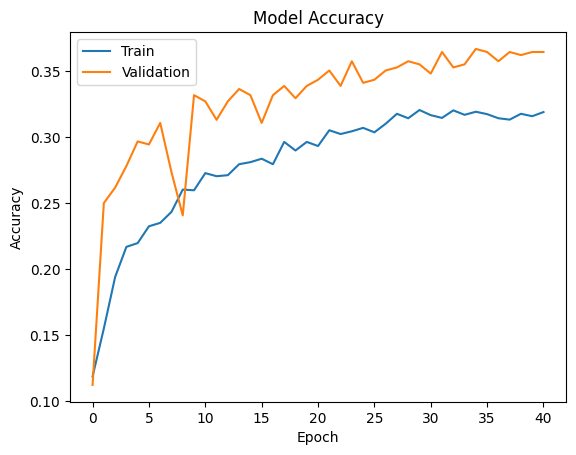

In [ ]:
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model6.evaluate(X_test_normalized1, y_test_encoded1, verbose=2)

15/15 - 2s - loss: 1.9071 - accuracy: 0.3263 - 2s/epoch - 118ms/step


15/15 [==============================] - 1s 39ms/step


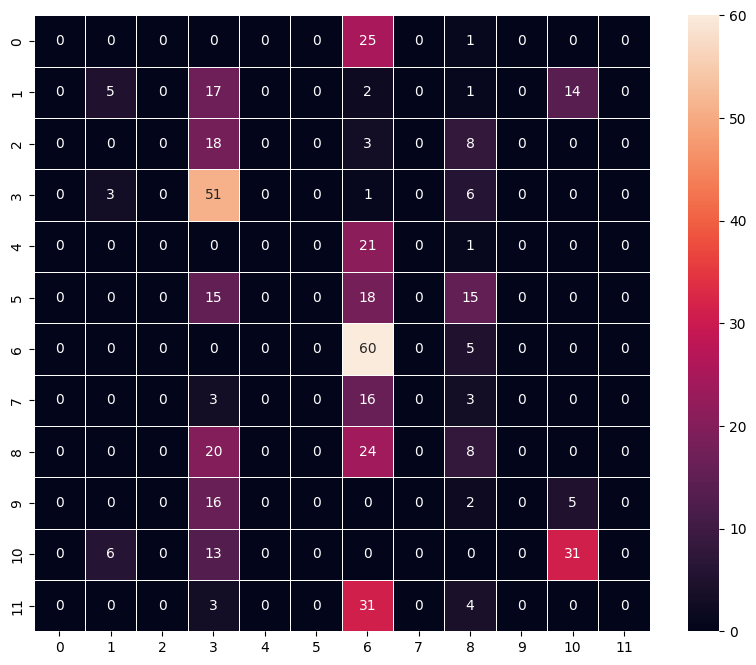

In [ ]:
y_pred6 = model6.predict(X_test_normalized1)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred6_arg=np.argmax(y_pred6,axis=1)
y_test_arg=np.argmax(y_test_encoded1,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred6_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [ ]:
cr6 =metrics.classification_report(y_test_arg,y_pred6_arg, output_dict=True)
f1_6 = cr6['macro avg']['f1-score']
acc_6 = cr6['accuracy']
print('f1-score:',f1_6)
print('Accuracy:', acc_6)


f1-score: 0.1567330453339679
Accuracy: 0.3263157894736842


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The VGG16 model, with no trainable Conv layers performed very poorly.

I will try a combination of the above transfer model but adding the full model4 after it, including model4's conv layers.

### Model7 VGG plus conv AND dense layers from model4

In [ ]:
# clearing the backend and setting the seeds
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model7 = Sequential()

#start with the pre-trained vgg layers
model7.add(model_vgg)

# conv layers from model4
model7.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model7.add(MaxPooling2D(2,2))
model7.add(BatchNormalization())
model7.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model7.add(MaxPooling2D(2,2))
model7.add(BatchNormalization())
model7.add(Conv2D(16, (3,3), activation='relu', padding='same'))
# model7.add(MaxPooling2D(2,2))
model7.add(BatchNormalization())
# Flatten
model7.add(Flatten())

# add the dense layers from model4 above
# ANN layers
model7.add(Dense(64, activation='relu'))
model7.add(Dropout((0.25)))
model7.add(Dense(32, activation='relu'))
model7.add(Dropout((0.25)))
model7.add(Dense(16, activation='relu'))

#output layer
model7.add(Dense(12, activation='softmax'))

In [ ]:
# compile with parameters from model4 above
model7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 64)          294976    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 64)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 3, 3, 64)         256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 32)          18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 32)         0

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5,) #restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, mode='auto', min_delta=0.00001)
callbacks = (early_stop, reduce_lr)

history7 = model7.fit(X_train_normalized1, y_train_encoded1,
                    validation_data=(X_val_normalized1, y_val_encoded1),
                    epochs=50,
                    batch_size=32,
                    verbose=2,
                    callbacks=callbacks
)

Epoch 1/50
121/121 - 10s - loss: 2.3647 - accuracy: 0.1619 - val_loss: 2.4106 - val_accuracy: 0.2220 - lr: 0.0010 - 10s/epoch - 86ms/step
Epoch 2/50
121/121 - 6s - loss: 1.9987 - accuracy: 0.3148 - val_loss: 1.9409 - val_accuracy: 0.3715 - lr: 0.0010 - 6s/epoch - 48ms/step
Epoch 3/50
121/121 - 6s - loss: 1.7224 - accuracy: 0.4107 - val_loss: 1.8324 - val_accuracy: 0.3949 - lr: 0.0010 - 6s/epoch - 47ms/step
Epoch 4/50
121/121 - 6s - loss: 1.4999 - accuracy: 0.4918 - val_loss: 1.8992 - val_accuracy: 0.4533 - lr: 0.0010 - 6s/epoch - 48ms/step
Epoch 5/50
121/121 - 6s - loss: 1.3366 - accuracy: 0.5370 - val_loss: 2.4789 - val_accuracy: 0.3715 - lr: 0.0010 - 6s/epoch - 48ms/step
Epoch 6/50
121/121 - 6s - loss: 1.1123 - accuracy: 0.6181 - val_loss: 1.7656 - val_accuracy: 0.5000 - lr: 5.0000e-04 - 6s/epoch - 48ms/step
Epoch 7/50
121/121 - 6s - loss: 1.0003 - accuracy: 0.6447 - val_loss: 1.0943 - val_accuracy: 0.6472 - lr: 5.0000e-04 - 6s/epoch - 48ms/step
Epoch 8/50
121/121 - 6s - loss: 0.9320

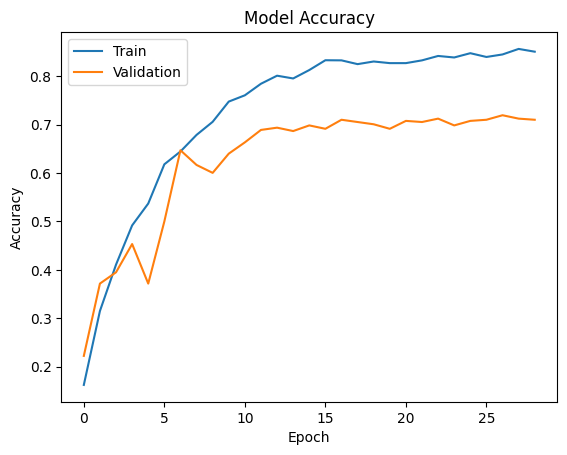

In [ ]:
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

This model does very well on the training data but clearly overfits and does not come back from it.  I tried with early stop turned off, and it just stayed staticly overfit ~90 and ~74(val) from 20 epochs on.

Will try this model with some data augmentation to see if theh overfitting can be improved.

In [ ]:
accuracy = model7.evaluate(X_test_normalized1, y_test_encoded1, verbose=2)

15/15 - 1s - loss: 0.9821 - accuracy: 0.7116 - 670ms/epoch - 45ms/step


15/15 [==============================] - 1s 39ms/step


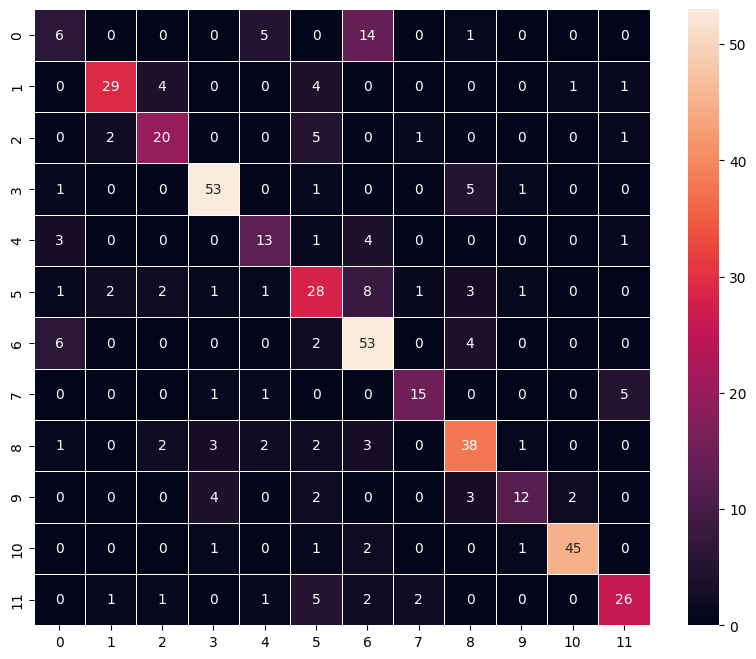

In [ ]:
y_pred7 = model7.predict(X_test_normalized1)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred7_arg=np.argmax(y_pred7,axis=1)
y_test_arg=np.argmax(y_test_encoded1,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred7_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [ ]:
cr7 =metrics.classification_report(y_test_arg,y_pred7_arg, output_dict=True)
f1_7 = cr7['macro avg']['f1-score']
acc_7 = cr7['accuracy']
print('f1-score:',f1_7)
print('Accuracy:', acc_7)


f1-score: 0.680152119571598
Accuracy: 0.7115789473684211


### Model8 VGG with conv and dense layers from Model4 Plus data augmentation

In [ ]:
# clearing the backend and setting the seeds
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
datagen = ImageDataGenerator (horizontal_flip=True,
                                    vertical_flip=False,
                                    height_shift_range=0.1,
                                    width_shift_range=0.1,
                                    rotation_range=90,
                                    zoom_range=0.1,
                                    )

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, start_from_epoch=15) #restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, mode='auto', min_delta=0.00001)
callbacks = (early_stop, reduce_lr)
model8 = model7
history8 = model8.fit(datagen.flow(X_train_normalized1, y_train_encoded1),
                    validation_data=(X_val_normalized1, y_val_encoded1),
                    epochs=50,
                    verbose=2,
                    batch_size=32,
                    steps_per_epoch=X_train.shape[0]/32,
                    callbacks=callbacks
)

Epoch 1/50
120/120 - 40s - loss: 1.6507 - accuracy: 0.5602 - val_loss: 0.9948 - val_accuracy: 0.6963 - lr: 3.9063e-06 - 40s/epoch - 334ms/step
Epoch 2/50
120/120 - 37s - loss: 1.6717 - accuracy: 0.5636 - val_loss: 1.0301 - val_accuracy: 0.7009 - lr: 3.9063e-06 - 37s/epoch - 311ms/step
Epoch 3/50
120/120 - 37s - loss: 1.5738 - accuracy: 0.5620 - val_loss: 1.0271 - val_accuracy: 0.6986 - lr: 3.9063e-06 - 37s/epoch - 310ms/step
Epoch 4/50
120/120 - 38s - loss: 1.4984 - accuracy: 0.5786 - val_loss: 1.0292 - val_accuracy: 0.7009 - lr: 1.9531e-06 - 38s/epoch - 314ms/step
Epoch 5/50
120/120 - 37s - loss: 1.5362 - accuracy: 0.5802 - val_loss: 1.0302 - val_accuracy: 0.7033 - lr: 1.9531e-06 - 37s/epoch - 308ms/step
Epoch 6/50
120/120 - 37s - loss: 1.4795 - accuracy: 0.5805 - val_loss: 1.0312 - val_accuracy: 0.7033 - lr: 9.7656e-07 - 37s/epoch - 305ms/step
Epoch 7/50
120/120 - 38s - loss: 1.4915 - accuracy: 0.5836 - val_loss: 1.0256 - val_accuracy: 0.7079 - lr: 9.7656e-07 - 38s/epoch - 312ms/step

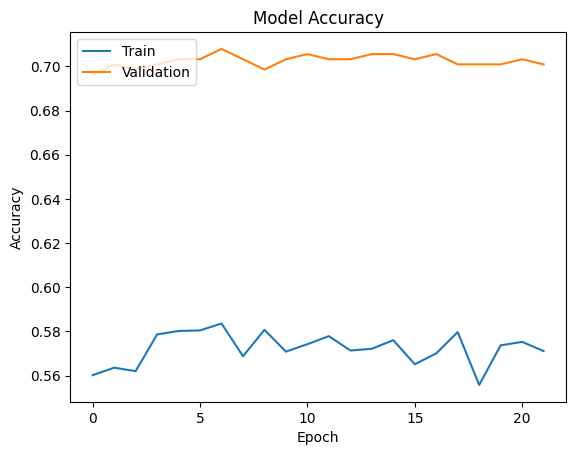

In [ ]:
plt.plot(history8.history['accuracy'])
plt.plot(history8.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model8.evaluate(X_test_normalized1, y_test_encoded1, verbose=2)

15/15 - 1s - loss: 1.0328 - accuracy: 0.6842 - 624ms/epoch - 42ms/step


15/15 [==============================] - 1s 39ms/step


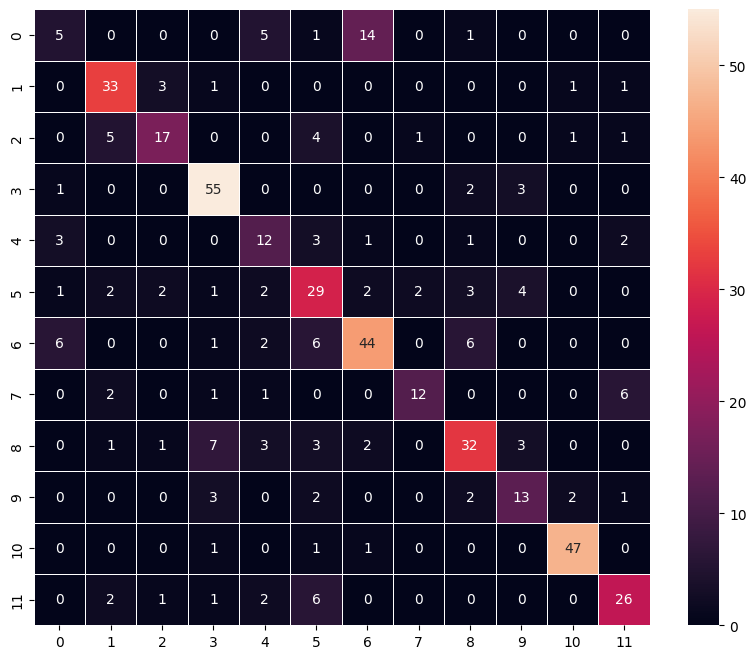

In [ ]:
y_pred8 = model8.predict(X_test_normalized1)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred8_arg=np.argmax(y_pred8,axis=1)
y_test_arg=np.argmax(y_test_encoded1,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred8_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [ ]:
cr8 =metrics.classification_report(y_test_arg,y_pred8_arg, output_dict=True)
f1_8 = cr8['macro avg']['f1-score']
acc_8 = cr8['accuracy']
print('f1-score:',f1_8)
print('Accuracy:', acc_8)


f1-score: 0.6431735531068782
Accuracy: 0.6842105263157895


In [ ]:
cnn_compare = pd.DataFrame({'Model1':[f1_1, acc_1],
                            'Model2':[f1_2, acc_2],
                            'Model3':[f1_3, acc_3],
                            'Model4':[f1_4, acc_4],
                            'Model5(model4 w/aug)':[f1_5, acc_5],
                            'Model6':[f1_6, acc_6],
                            'Model7(VGG)':[f1_7, acc_7],
                            'Model8(VGG w/aug)':[f1_8, acc_8]},
                            index=['f1', 'acc'])
cnn_compare

,Model1,Model2,Model3,Model4,Model5(model4 w/aug),Model6,Model7(VGG),Model8(VGG w/aug)
f1,0.600689,0.720458,0.640299,0.836421,0.824565,0.156733,0.680152,0.643174
acc,0.684211,0.757895,0.665263,0.856842,0.840000,0.326316,0.711579,0.684211


### Model4 with Gaussian Blur

In [ ]:
X_tempB, X_testB, y_tempB, y_testB = train_test_split(np.array(images_gb), labels, test_size=0.1, random_state=1, stratify=labels)

In [ ]:
X_trainB, X_valB, y_trainB, y_valB = train_test_split(X_tempB, y_tempB, test_size = 0.1, random_state=1, stratify = y_temp)

In [ ]:
print("X_trainB:", X_trainB.shape)
print("y_trainB:", y_trainB.shape)
print("X_valB:", X_valB.shape)
print("y_valB:", y_valB.shape)
print("X_testB:", X_testB.shape)
print("y_testB:", y_testB.shape)


X_trainB: (3847, 64, 64, 3)
y_trainB: (3847, 1)
X_valB: (428, 64, 64, 3)
y_valB: (428, 1)
X_testB: (475, 64, 64, 3)
y_testB: (475, 1)


In [ ]:
# convert the labels from names to OHE vectors
enc = LabelBinarizer()
y_train_encodedB = enc.fit_transform(y_trainB)
y_val_encodedB = enc.transform(y_valB)
y_test_encodedB = enc.transform(y_testB)

In [ ]:
# normalize the pixel values, convert from 0-255 to 0-1
X_train_normalizedB = X_trainB.astype('float32')/255.0
X_val_normalizedB = X_valB.astype('float32')/255.0
X_test_normalizedB = X_testB.astype('float32')/255.0

In [ ]:
# clearing the backend and setting the seeds
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [ ]:
# initialize the model as sequential
model4B = Sequential()

In [ ]:
# start with a conv layer
model4B.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(64,64,3)))
model4B.add(MaxPooling2D(2,2))
model4B.add(BatchNormalization())
model4B.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model4B.add(MaxPooling2D(2,2))
model4B.add(BatchNormalization())
model4B.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model4B.add(MaxPooling2D(2,2))
model4B.add(BatchNormalization())

# flatten
model4B.add(Flatten())

# ANN layers
model4B.add(Dense(64, activation='relu'))
model4B.add(Dropout((0.25)))
model4B.add(Dense(32, activation='relu'))
model4B.add(Dropout((0.25)))
model4B.add(Dense(16, activation='relu'))

#output layer
model4B.add(Dense(12, activation='softmax'))

In [ ]:
model4B.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4B.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                        

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5,) #restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, mode='auto', min_delta=0.00001)
callbacks = (early_stop, reduce_lr)

history4B = model4.fit(X_train_normalizedB, y_train_encodedB,
                    validation_data=(X_val_normalizedB, y_val_encodedB),
                    epochs=50,
                    batch_size=32,
                    verbose=2,
                    callbacks=callbacks
)

Epoch 1/50
121/121 - 1s - loss: 0.3863 - accuracy: 0.8731 - val_loss: 0.6044 - val_accuracy: 0.8224 - lr: 1.5625e-14 - 955ms/epoch - 8ms/step
Epoch 2/50
121/121 - 1s - loss: 0.3705 - accuracy: 0.8776 - val_loss: 0.5955 - val_accuracy: 0.8224 - lr: 1.5625e-14 - 611ms/epoch - 5ms/step
Epoch 3/50
121/121 - 1s - loss: 0.3749 - accuracy: 0.8742 - val_loss: 0.5945 - val_accuracy: 0.8271 - lr: 1.5625e-14 - 591ms/epoch - 5ms/step
Epoch 4/50
121/121 - 1s - loss: 0.3828 - accuracy: 0.8705 - val_loss: 0.5939 - val_accuracy: 0.8271 - lr: 1.5625e-14 - 598ms/epoch - 5ms/step
Epoch 5/50
121/121 - 1s - loss: 0.3686 - accuracy: 0.8820 - val_loss: 0.5942 - val_accuracy: 0.8271 - lr: 1.5625e-14 - 599ms/epoch - 5ms/step
Epoch 6/50
121/121 - 1s - loss: 0.3709 - accuracy: 0.8770 - val_loss: 0.5942 - val_accuracy: 0.8271 - lr: 1.5625e-14 - 593ms/epoch - 5ms/step
Epoch 7/50
121/121 - 1s - loss: 0.3690 - accuracy: 0.8789 - val_loss: 0.5945 - val_accuracy: 0.8248 - lr: 7.8125e-15 - 593ms/epoch - 5ms/step
Epoch 

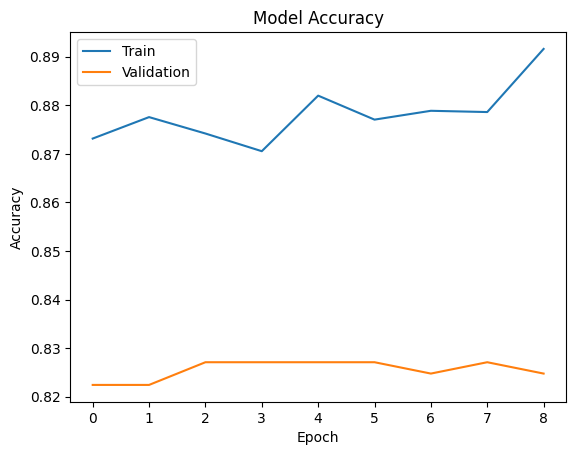

In [ ]:
plt.plot(history4B.history['accuracy'])
plt.plot(history4B.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model4B.evaluate(X_test_normalizedB, y_test_encodedB, verbose=2)

15/15 - 0s - loss: 2.4886 - accuracy: 0.0989 - 343ms/epoch - 23ms/step


15/15 [==============================] - 0s 2ms/step


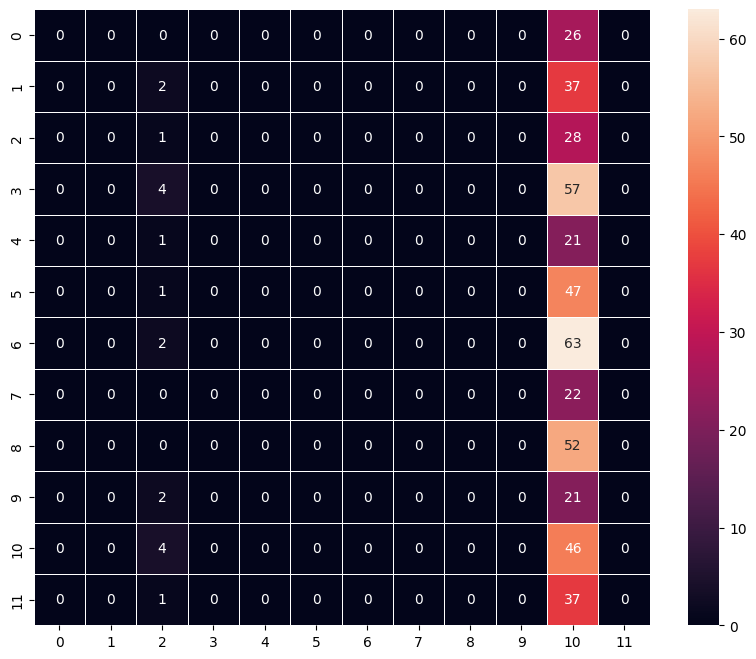

In [ ]:
y_pred4B = model4B.predict(X_test_normalizedB)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred4B_arg=np.argmax(y_pred4B,axis=1)
y_testB_arg=np.argmax(y_test_encodedB,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_testB_arg,y_pred4B_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [ ]:
cr4B =metrics.classification_report(y_testB_arg,y_pred4B_arg, output_dict=True)
f1_4B = cr4B['macro avg']['f1-score']
acc_4B = cr4B['accuracy']
print('f1-score:',f1_4B)
print('Accuracy:', acc_4B)


f1-score: 0.018667729797026036
Accuracy: 0.09894736842105263


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 4 on the Gaussian Blurred images did not work well.  The model predicted almost all of the images as plant type 10.

## Final Model model4



In [ ]:
cnn_compare = pd.DataFrame({'Model1':[f1_1, acc_1],
                            'Model2':[f1_2, acc_2],
                            'Model3':[f1_3, acc_3],
                            'Model4':[f1_4, acc_4],
                            'Model5(model4 w/aug)':[f1_5, acc_5],
                            'Model6':[f1_6, acc_6],
                            'Model7(VGG)':[f1_7, acc_7],
                            'Model8(VGG w/aug)':[f1_8, acc_8],
                            'Model4B (blur)':[f1_4B, acc_4B]},
                            index=['f1', 'acc'])
cnn_compare

,Model1,Model2,Model3,Model4,Model5(model4 w/aug),Model6,Model7(VGG),Model8(VGG w/aug),Model4B (blur)
f1,0.600689,0.720458,0.640299,0.836421,0.824565,0.156733,0.680152,0.643174,0.018668
acc,0.684211,0.757895,0.665263,0.856842,0.840000,0.326316,0.711579,0.684211,0.098947


### Visualizing the prediction

In [ ]:
accuracy = model4.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.6783 - accuracy: 0.7874 - 56ms/epoch - 4ms/step


15/15 [==============================] - 0s 3ms/step


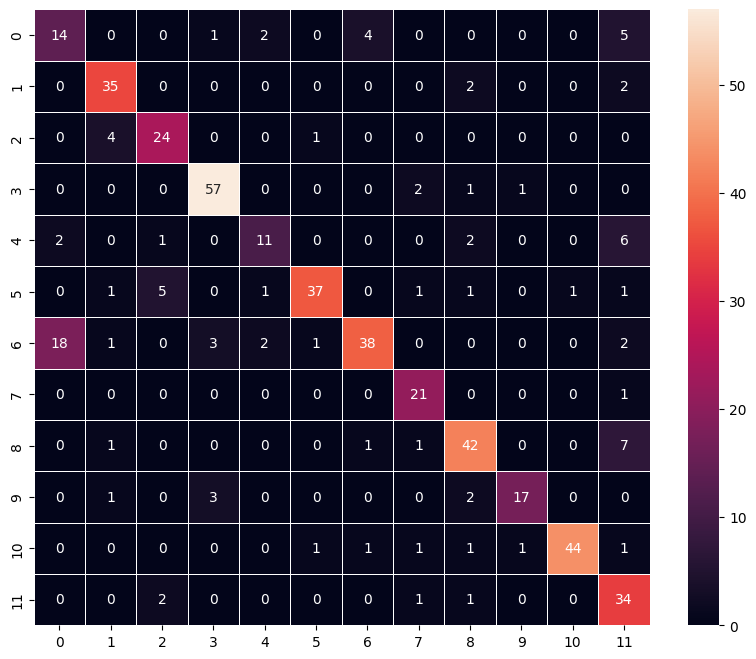

In [ ]:
y_pred4 = model4.predict(X_test_normalized)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred4_arg=np.argmax(y_pred4,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred4_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

## Actionable Insights and Business Recommendations

I recommend using model 4.  It is accurate to between 76 and 80%, which will drastically reduce the amount of manual classification work for farmers.  This model has the added benefit of requiring little image preprocessing and no costly data augmentation.


_____